# Original Central Model for the NYC Taxi DataSet

In [1]:
import collections
import functools
import os
import time

import numpy as np
import tensorflow as tf
import pandas as pd

np.random.seed(0)

from tensorflow import feature_column
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split

import os
import time
import sys

from tqdm import tqdm


# Dataset

Only use the first 10000000 rows to decrease training time.

In [2]:
# read the dataset from Drive
df = pd.read_csv("./ma_results/trips_with_zones_final.csv")
df = df.head(10000000)
df.head(10)

,medallion,pickup_week_day,pickup_hour,pickup_day,pickup_month,dropoff_week_day,dropoff_hour,dropoff_day,dropoff_month,pickup_location_id,dropoff_location_id
0,00005007A9F30E289E760362F69E4EAD,1,0,1,1,1,0,1,1,162.0,262.0
1,00005007A9F30E289E760362F69E4EAD,1,0,1,1,1,0,1,1,262.0,239.0
2,00005007A9F30E289E760362F69E4EAD,1,0,1,1,1,1,1,1,239.0,236.0
3,00005007A9F30E289E760362F69E4EAD,1,1,1,1,1,1,1,1,236.0,41.0
4,00005007A9F30E289E760362F69E4EAD,1,1,1,1,1,1,1,1,41.0,211.0
5,00005007A9F30E289E760362F69E4EAD,1,1,1,1,1,2,1,1,211.0,238.0
6,00005007A9F30E289E760362F69E4EAD,1,2,1,1,1,2,1,1,238.0,142.0
7,00005007A9F30E289E760362F69E4EAD,1,2,1,1,1,2,1,1,142.0,263.0
8,00005007A9F30E289E760362F69E4EAD,1,2,1,1,1,3,1,1,263.0,48.0
9,00005007A9F30E289E760362F69E4EAD,1,3,1,1,1,3,1,1,48.0,246.0


In [3]:
# Check dtypes of the attributes
df.dtypes

medallion               object
pickup_week_day          int64
pickup_hour              int64
pickup_day               int64
pickup_month             int64
dropoff_week_day         int64
dropoff_hour             int64
dropoff_day              int64
dropoff_month            int64
pickup_location_id     float64
dropoff_location_id    float64
dtype: object

Medallion is not needed for the central approach.

In [4]:
# Drop the medallion, it is not needed for this example
df.drop(['medallion'], axis=1, inplace=True)

In [5]:
# Cast the columns type to int32
dictionary = {'pickup_week_day': 'int32', 'pickup_hour': 'int32', 'pickup_day': 'int32', 'pickup_month': 'int32', 'dropoff_week_day': 'int32', 'dropoff_hour': 'int32', 'dropoff_day': 'int32', 'dropoff_month': 'int32', 'pickup_location_id':'int32', 'dropoff_location_id':'int32'}
df = df.astype(dictionary, copy=True)
df.dtypes

pickup_week_day        int32
pickup_hour            int32
pickup_day             int32
pickup_month           int32
dropoff_week_day       int32
dropoff_hour           int32
dropoff_day            int32
dropoff_month          int32
pickup_location_id     int32
dropoff_location_id    int32
dtype: object

We can use the other taxis to create a local test and validation sets

In [6]:
# function to remove duplicates
def create_sequence(locations): 
  # Flatten the list of places
  sequence = np.reshape(locations.values, [-1])

  # Create a temporary array of the same lenght of the sequece of locations
  copy = np.zeros(sequence.shape[0], dtype=np.int32)

  # Copy the sequence of location in the copy array but shifted right by 1 position
  # The last location does not need to be copied, it can't be a duplicate
  copy[1:] = sequence[:sequence.shape[0]-1]

  # Where we get 0 it can be a possible duplicated
  duplicated = sequence - copy

  # indices where the subtraction gives 0
  idx = np.where(duplicated == 0)[0]

  # Find where the position of the zeros are even
  even = idx%2 == 0

  # List the indices where the position is even and the subtraction gave 0
  to_drop = idx[even]

  # Remove the duplicates
  clean_sequence = np.delete(sequence, to_drop)
  return clean_sequence, to_drop

Now we need to create the location sequence for each user

In [7]:
def df_to_location_sequence(df):
  
  # take just the columns we need
  locations = df[['pickup_location_id','dropoff_location_id']].copy()
  locations = locations.astype('int32')


  # define the indices to keep trace of the locations
  x = np.arange(0, locations.values.shape[0])

  pos = np.array([x,x]).T
  pos = np.reshape(pos, [-1])

  # Represent whether the location is a pickup or a dropoff
  pick = np.zeros(locations.values.shape[0], dtype=int)
  drop = np.ones(locations.values.shape[0], dtype=int)

  loc = np.array([pick,drop]).T
  loc = np.reshape(loc, [-1])

  # Generate the sequence of places
  sequence, duplicates = create_sequence(locations)

  # We use now the indices of the duplicated locations to clean also the array of rows and the array of location types
  pos = np.delete(pos, duplicates)
  loc = np.delete(loc, duplicates)

  # Select the indices of records we want the pickup location
  pick_pos = pos[pos[loc == 0]]

  # Select the indices of records we want the dropoff location
  drop_pos = pos[pos[loc == 1]]

  
  records_pick = df.iloc[pick_pos][['pickup_location_id', 'pickup_week_day',	'pickup_hour',	'pickup_day',	'pickup_month']]
  records_pick = records_pick.rename(columns={'pickup_location_id': 'location_id', 'pickup_week_day':'week_day' ,	'pickup_hour':'hour' ,	'pickup_day':	'day' ,	'pickup_month':'month' })

  idx_drop = np.nonzero(loc == 0)[0]
  records_drop = df.iloc[drop_pos][['dropoff_location_id', 'dropoff_week_day',	'dropoff_hour',	'dropoff_day',	'dropoff_month']]
  records_drop = records_drop.rename(columns={'dropoff_location_id': 'location_id', 'dropoff_week_day':'week_day' ,	'dropoff_hour':'hour' ,	'dropoff_day':	'day' ,	'dropoff_month':'month' })

  locations_sequence = pd.concat([records_pick, records_drop])

  # reset the index
  locations_sequence.reset_index(inplace=True)

  # From hour to sin-cos representation
  locations_sequence['hour_sin'] = np.sin(locations_sequence.hour*(2.*np.pi/24))
  locations_sequence['hour_cos'] = np.cos(locations_sequence.hour*(2.*np.pi/24))

  locations_sequence['week_day_sin'] = np.sin(locations_sequence.week_day*(2.*np.pi/7))
  locations_sequence['week_day_cos'] = np.cos(locations_sequence.week_day*(2.*np.pi/7))


  # Drop the original column
  locations_sequence.drop(['hour'], axis=1, inplace=True)
  

  # Helper function to encode the day_type
  def is_weekend(days):
    weekends = np.zeros(len(days))
    weekends[((days == 5) | (days == 6))] = 1
    return weekends

  # Apply the helper function to all the records
  locations_sequence['weekend'] = is_weekend(locations_sequence['week_day'])

  # the column is not needed anymore
  locations_sequence.drop(['week_day'], axis=1, inplace=True)

  # Correct the weekend feature type
  dictionary = {'weekend': 'int32'}
  locations_sequence = locations_sequence.astype(dictionary, copy=True)
  
  return locations_sequence, pos, loc

# Call the function
locations_sequence, pos, loc = df_to_location_sequence(df)

print(locations_sequence)

            index  location_id  day  month  hour_sin      hour_cos  \
0               0          162    1      1  0.000000  1.000000e+00   
1              12          230    1      1  0.707107  7.071068e-01   
2              13          125    1      1  0.707107  7.071068e-01   
3              15           48    1      1  0.866025  5.000000e-01   
4              18          170    1      1  1.000000  6.123234e-17   
...           ...          ...  ...    ...       ...           ...   
13731996  7284341          161   26      1 -0.500000 -8.660254e-01   
13731997  7284341          161   26      1 -0.500000 -8.660254e-01   
13731998  7284342          132   26      1 -0.707107 -7.071068e-01   
13731999  7284343          141   26      1 -0.866025 -5.000000e-01   
13732000  7284344          141   26      1 -0.866025 -5.000000e-01   

          week_day_sin  week_day_cos  weekend  
0             0.781831      0.623490        0  
1             0.781831      0.623490        0  
2             0

In [8]:
# Split in train, test and validation
train, test = train_test_split(locations_sequence, test_size=0.2, shuffle=False)
train, val = train_test_split(train, test_size=0.2, shuffle=False)
print(len(train), 'train examples')
print(len(val), 'validation examples')
print(len(test), 'test examples')

8788480 train examples
2197120 validation examples
2746401 test examples


In [9]:

# Split the data into chunks
N = 129
# Train
# Get a list of dataframes of length n records
list_train = [train[i:i+N] for i in range(0, train.shape[0], N)]

# Validation
# Get a list of dataframes of length n records
list_val = [val[i:i+N] for i in range(0, val.shape[0], N)]

# Test
# Get a list of dataframes of length n records
list_test = [test[i:i+N] for i in range(0, test.shape[0], N)]
list_test[0]


,index,location_id,day,month,hour_sin,hour_cos,week_day_sin,week_day_cos,weekend
10985600,5283998,246,4,1,-0.866025,0.500000,-0.433884,-0.900969,0
10985601,5283999,107,4,1,-0.707107,0.707107,-0.433884,-0.900969,0
10985602,5284000,142,4,1,-0.707107,0.707107,-0.433884,-0.900969,0
10985603,5284001,48,4,1,-0.500000,0.866025,-0.433884,-0.900969,0
10985604,5284001,48,4,1,-0.500000,0.866025,-0.433884,-0.900969,0
...,...,...,...,...,...,...,...,...,...
10985724,5284091,234,7,1,0.000000,1.000000,0.000000,1.000000,0
10985725,5284092,162,7,1,0.258819,0.965926,0.000000,1.000000,0
10985726,5284093,142,7,1,0.500000,0.866025,0.000000,1.000000,0
10985727,5284093,142,7,1,0.500000,0.866025,0.000000,1.000000,0


In [10]:
if len(list_train[-1]) < N:
  diff_train = 1
else:
  diff_train = 0

if len(list_val[-1]) < N:
  diff_val = 1
else:
  diff_val = 0

if len(list_test[-1]) < N:
  diff_test = 1
else:
  diff_test = 0

# Define the input features of the  dataset
train_input_dict = {
  'start_place':np.array([list_train[i]['location_id'].values[:-1] for i in range(0, len(list_train)-diff_train)]),
  'start_hour_sin':np.array([list_train[i]['hour_sin'].values[:-1] for i in range(0, len(list_train)-diff_train)]),
  'start_hour_cos':np.array([list_train[i]['hour_cos'].values[:-1] for i in range(0, len(list_train)-diff_train)]),
  'weekend':np.array([list_train[i]['weekend'].values[:-1] for i in range(0, len(list_train)-diff_train)]),
  'week_day_sin':np.array([list_train[i]['week_day_sin'].values[:-1] for i in range(0, len(list_train)-diff_train)]),
  'week_day_cos':np.array([list_train[i]['week_day_cos'].values[:-1] for i in range(0, len(list_train)-diff_train)]),
}

# Define the input features of the  dataset
val_input_dict = {
  'start_place':np.array([list_val[i]['location_id'].values[:-1] for i in range(0, len(list_val)-diff_val)]),
  'start_hour_sin':np.array([list_val[i]['hour_sin'].values[:-1] for i in range(0, len(list_val)-diff_val)]),
  'start_hour_cos':np.array([list_val[i]['hour_cos'].values[:-1] for i in range(0, len(list_val)-diff_val)]),
  'weekend':np.array([list_val[i]['weekend'].values[:-1] for i in range(0, len(list_val)-diff_val)]),
  'week_day_sin':np.array([list_val[i]['week_day_sin'].values[:-1] for i in range(0, len(list_val)-diff_val)]),
  'week_day_cos':np.array([list_val[i]['week_day_cos'].values[:-1] for i in range(0, len(list_val)-diff_val)]),
}

# Define the input features of the  dataset
test_input_dict = {
  'start_place':np.array([list_test[i]['location_id'].values[:-1] for i in range(0, len(list_test)-diff_test)]),
  'start_hour_sin':np.array([list_test[i]['hour_sin'].values[:-1] for i in range(0, len(list_test)-diff_test)]),
  'start_hour_cos':np.array([list_test[i]['hour_cos'].values[:-1] for i in range(0, len(list_test)-diff_test)]),
  'weekend':np.array([list_test[i]['weekend'].values[:-1] for i in range(0, len(list_test)-diff_test)]),
  'week_day_sin':np.array([list_test[i]['week_day_sin'].values[:-1] for i in range(0, len(list_test)-diff_test)]),
  'week_day_cos':np.array([list_test[i]['week_day_cos'].values[:-1] for i in range(0, len(list_test)-diff_test)]),
}
# Create training examples / targets, we are going to predict the next location
trips_dataset_train = tf.data.Dataset.from_tensor_slices((train_input_dict, np.array([list_train[i]['location_id'].values[1:] for i in range(0, len(list_train)-diff_train)])))
trips_dataset_val = tf.data.Dataset.from_tensor_slices((val_input_dict, np.array([list_val[i]['location_id'].values[1:] for i in range(0, len(list_val)-diff_val)])) )
trips_dataset_test = tf.data.Dataset.from_tensor_slices((test_input_dict, np.array([list_test[i]['location_id'].values[1:] for i in range(0, len(list_test)-diff_test)])) )

# Batch size
BATCH_SIZE = 128

# Buffer size to shuffle the dataset
# (TF data is designed to work with possibly infinite sequences,
# so it doesn't attempt to shuffle the entire sequence in memory. Instead,
# it maintains a buffer in which it shuffles elements).
BUFFER_SIZE = 10000

# Create the dataset by creating batches
# Uncomment the shuffle function in case we want to shuffle the sequences
train_dataset = trips_dataset_train.batch(BATCH_SIZE, drop_remainder=True) #.shuffle(BUFFER_SIZE)
val_dataset = trips_dataset_val.batch(BATCH_SIZE, drop_remainder=True) #.shuffle(BUFFER_SIZE)
test_dataset = trips_dataset_test.batch(BATCH_SIZE, drop_remainder=True) #.shuffle(BUFFER_SIZE)

In [11]:
# All the different places in the dataset
indices = locations_sequence.location_id.values

# Length of the vocabulary of places (e.g. 11)
vocab_size = int(np.max(indices) + 1) # + 1 because of 0

# The embedding dimension
embedding_dim = 256

# Number of RNN units
rnn_units = 256

# List of numerical column names
numerical_column_names = ['start_hour_sin', 'start_hour_cos', 'weekend', 'week_day']

# Number of different places
number_of_places =  max(locations_sequence.location_id.max(), locations_sequence.location_id.max()) + 1

In [12]:
# Create a model
def create_model(number_of_places, batch_size):

	# Shortcut to the layers package
  l = tf.keras.layers

  # List of numeric feature columns to pass to the DenseLayer
  numeric_feature_columns = []


  # Handling numerical columns
  for header in numerical_column_names:
		# Append all the numerical columns defined into the list
    numeric_feature_columns.append(feature_column.numeric_column(header, shape=N-1))

  # Now we need to define an input dictionary.
	# Where the keys are the column names
	# This is a model with multiple inputs, so we need to declare and input layer for each feature
  feature_inputs = {
    'start_hour_sin': tf.keras.Input((N-1, ), batch_size=batch_size, name='start_hour_sin'),
    'start_hour_cos': tf.keras.Input((N-1, ), batch_size=batch_size, name='start_hour_cos'),
    'weekend': tf.keras.Input((N-1, ), batch_size=batch_size, name='weekend'),
    'week_day_sin': tf.keras.Input((N-1, ), batch_size=batch_size, name='week_day_sin'),
    'week_day_cos': tf.keras.Input((N-1, ), batch_size=batch_size, name='week_day_cos'),
  }

  # We declare two DenseFeature layers, one for the numeric columns which do not require\
	# Any training, and one for the categorical. It is easier to do it like this
  '''numerical_features = l.DenseFeatures(numeric_feature_columns)(feature_inputs)'''

  # We cannot use anarray of features as always because we have sequences and we cannot match the shape otherwise
  # We have to do one by one
  start_hour_sin = feature_column.numeric_column("start_hour_sin", shape=(N-1))
  hour_sin_feature = l.DenseFeatures(start_hour_sin)(feature_inputs)

  start_hour_cos = feature_column.numeric_column("start_hour_cos", shape=(N-1))
  hour_cos_feature = l.DenseFeatures(start_hour_cos)(feature_inputs)

  weekend = feature_column.numeric_column("weekend", shape=(N-1))
  weekend_feature = l.DenseFeatures(weekend)(feature_inputs)

  week_day_sin = feature_column.numeric_column("week_day_sin", shape=(N-1))
  week_day_sin_feature = l.DenseFeatures(week_day_sin)(feature_inputs)

  week_day_cos = feature_column.numeric_column("week_day_cos", shape=(N-1))
  week_day_cos_feature = l.DenseFeatures(week_day_cos)(feature_inputs)

	# We have also to add a dimension to then concatenate
  hour_sin_feature = tf.expand_dims(hour_sin_feature, -1)
  hour_cos_feature = tf.expand_dims(hour_cos_feature, -1)
  weekend_feature = tf.expand_dims(weekend_feature, -1)
  week_day_sin_feature = tf.expand_dims(week_day_sin_feature, -1)
  week_day_cos_feature = tf.expand_dims(week_day_cos_feature, -1)

  # Declare the dictionary for the places sequence as before
  sequence_input = {
      'start_place': tf.keras.Input((N-1,), batch_size=batch_size, dtype=tf.dtypes.int32, name='start_place') # add batch_size=batch_size in case of stateful GRU
  }


  # Handling the categorical feature sequence using one-hot
  places_one_hot = feature_column.sequence_categorical_column_with_vocabulary_list(
      'start_place', [i for i in range(number_of_places)])

  # Embed the one-hot encoding
  places_embed = feature_column.embedding_column(places_one_hot, embedding_dim)


  # With an input sequence we can't use the DenseFeature layer, we need to use the SequenceFeatures
  sequence_features, sequence_length = tf.keras.experimental.SequenceFeatures(places_embed)(sequence_input)

  input_sequence = l.Concatenate(axis=2)([ sequence_features, hour_sin_feature, hour_cos_feature, weekend_feature, week_day_sin_feature, week_day_cos_feature])

  # Rnn
  recurrent = l.GRU(rnn_units,
                        batch_size=batch_size, #in case of stateful
                        return_sequences=True,
                        stateful=True,
                        recurrent_initializer='glorot_uniform')(input_sequence)


	# Last layer with an output for each places
  dense_1 = layers.Dense(number_of_places)(recurrent)

	# Softmax output layer
  output = l.Softmax()(dense_1)

	# To return the Model, we need to define its inputs and outputs
	# In out case, we need to list all the input layers we have defined
  inputs = list(feature_inputs.values()) + list(sequence_input.values())

	# Return the Model
  return tf.keras.Model(inputs=inputs, outputs=output)

In [13]:
# Get the model and compile it
model = create_model(number_of_places, batch_size=BATCH_SIZE)
# Define the optimizer
adam = tf.keras.optimizers.Adam(lr=0.001)
#tf.random.set_seed(1)

# Compile the model
model.compile(optimizer=adam,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=tf.keras.metrics.SparseCategoricalAccuracy())

# Training

In [14]:
N_EPOCHS = 10

# Fit the model
callback = tf.keras.callbacks.EarlyStopping(monitor='val_sparse_categorical_accuracy', patience=3, restore_best_weights=True, verbose=1)

model.fit(train_dataset,  validation_data=val_dataset, epochs=N_EPOCHS, callbacks=[callback])

Epoch 1/10
532/532 [==============================] - 130s 245ms/step - loss: 3.6745 - sparse_categorical_accuracy: 0.2100 - val_loss: 3.3742 - val_sparse_categorical_accuracy: 0.2863
Epoch 2/10
532/532 [==============================] - 127s 238ms/step - loss: 3.5733 - sparse_categorical_accuracy: 0.2268 - val_loss: 3.3436 - val_sparse_categorical_accuracy: 0.2919
Epoch 3/10
532/532 [==============================] - 130s 244ms/step - loss: 3.5582 - sparse_categorical_accuracy: 0.2291 - val_loss: 3.3287 - val_sparse_categorical_accuracy: 0.2946
Epoch 4/10
532/532 [==============================] - 121s 227ms/step - loss: 3.5490 - sparse_categorical_accuracy: 0.2302 - val_loss: 3.3186 - val_sparse_categorical_accuracy: 0.2959
Epoch 5/10
532/532 [==============================] - 114s 215ms/step - loss: 3.5422 - sparse_categorical_accuracy: 0.2310 - val_loss: 3.3112 - val_sparse_categorical_accuracy: 0.2967
Epoch 6/10
532/532 [==============================] - 115s 216ms/step - loss: 3.

# Evaluate

In [15]:
model.evaluate(test_dataset)

166/166 [==============================] - 12s 75ms/step - loss: 3.3298 - sparse_categorical_accuracy: 0.2978


[3.3297524452209473, 0.29783207178115845]

In [16]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
start_hour_cos (InputLayer)     [(128, 128)]         0                                            
__________________________________________________________________________________________________
start_hour_sin (InputLayer)     [(128, 128)]         0                                            
__________________________________________________________________________________________________
week_day_cos (InputLayer)       [(128, 128)]         0                                            
__________________________________________________________________________________________________
week_day_sin (InputLayer)       [(128, 128)]         0                                            
_______________________________________________________________________________________

Take a look at the prediction results and the actual values.

In [17]:
def print_info(arr, name):
  print(name)
  print('Shape : ', arr.shape)
  print('Example [0] : ', arr[0])
  if len(arr.shape) > 2:
    print('2nd axis example : ', arr[0][:][0])

In [21]:
logits = model.predict(test_dataset)
print_info(logits, 'logits')

predictions = tf.nn.softmax(logits, axis=2)
print_info(predictions, 'predictions')

predicted_classes = np.argmax(predictions, 2)
print_info(predicted_classes, 'predicted_classes')

actual_values = []
X_loc = []
for x, y in test_dataset.unbatch():
    actual_values.append(y.numpy())
    X_loc.append(x['start_place'].numpy())

actual_values = np.array(actual_values)
print(actual_values)
X_loc = np.array(X_loc)

diff = actual_values - predicted_classes
print(diff.shape)
unique, counts = np.unique(diff, return_counts=True)

print_info(actual_values, 'actual_values')
print_info(predicted_classes, 'predicted_classes')
print_info(diff, 'diff')

logits
Shape :  (21248, 128, 264)
Example [0] :  [[1.23480940e-03 2.77327053e-04 2.92404252e-07 ... 2.29773787e-03
  2.46089185e-03 4.39194916e-03]
 [1.04392483e-03 7.96494714e-05 9.06989115e-08 ... 2.06999807e-03
  5.94193023e-03 1.22365663e-02]
 [6.16767211e-04 3.46568631e-05 1.06633685e-07 ... 6.62028207e-04
  7.86628295e-03 1.44384634e-02]
 ...
 [3.46071203e-03 4.23661200e-04 1.09677489e-06 ... 3.15198791e-03
  7.70623889e-03 1.23121254e-02]
 [1.30544894e-03 2.66288087e-04 1.17361560e-06 ... 1.61789998e-03
  5.51854074e-03 1.53062353e-02]
 [2.27255537e-03 8.82225460e-04 4.66534573e-07 ... 3.74026108e-03
  8.31696671e-03 2.04047505e-02]]
2nd axis example :  [1.23480940e-03 2.77327053e-04 2.92404252e-07 1.23677110e-05
 2.54949811e-03 1.32932439e-06 5.42723183e-06 1.16130721e-03
 8.27820804e-06 1.88708309e-05 1.08640379e-05 1.28767069e-05
 2.52931641e-04 8.32069293e-03 2.69986922e-04 3.92361180e-05
 5.69729636e-05 1.09699927e-03 2.81202701e-05 6.68064386e-05
 8.94613277e-06 3.93737209

In [22]:
wrong = np.count_nonzero(diff)
size = diff.shape[0] * diff.shape[1]
correct =  size - wrong
acc = correct / size
print('# correct Predictions : ', correct)
print('# wrong Predictions : ', wrong)
print('accuracy: ', acc)

# correct Predictions :  806414
# wrong Predictions :  1913330
accuracy:  0.29650364151920183


In [23]:
for i in range(0,20):
  for j in range(0,128):
    print('Prediction #', (i,j))
    print('Actual values: ', actual_values[i][j])
    print('Predicted values: ', predicted_classes[i][j])

Prediction # (0, 0)
Actual values:  107
Predicted values:  246
Prediction # (0, 1)
Actual values:  142
Predicted values:  107
Prediction # (0, 2)
Actual values:  48
Predicted values:  142
Prediction # (0, 3)
Actual values:  48
Predicted values:  48
Prediction # (0, 4)
Actual values:  158
Predicted values:  48
Prediction # (0, 5)
Actual values:  68
Predicted values:  158
Prediction # (0, 6)
Actual values:  79
Predicted values:  68
Prediction # (0, 7)
Actual values:  79
Predicted values:  79
Prediction # (0, 8)
Actual values:  263
Predicted values:  79
Prediction # (0, 9)
Actual values:  263
Predicted values:  263
Prediction # (0, 10)
Actual values:  137
Predicted values:  229
Prediction # (0, 11)
Actual values:  137
Predicted values:  137
Prediction # (0, 12)
Actual values:  163
Predicted values:  79
Prediction # (0, 13)
Actual values:  238
Predicted values:  163
Prediction # (0, 14)
Actual values:  166
Predicted values:  238
Prediction # (0, 15)
Actual values:  151
Predicted values:  1

In [24]:
res = pd.DataFrame(predicted_classes)
unique, counts = np.unique(res, return_counts=True)
counts

array([  4838,   2064,     75,   9224,      8,     50,  10673,     55,
           73,    278,    101,    968,  19107,   1473,     93,    207,
         2807,    211,     48,    169,    187,    280,     28,   5669,
         4200,    324,    355,    147,      3,     53,    110,   5561,
          216,    121,   1468,   3383,     50,    182,   2353,  10485,
         5413,  34208,      8,   6115,      9,    104,  73840,   3811,
        21857,    138,   1735,    117,    525,    141,    396,   4541,
           35,     14,     61,   2736,    720,    106,     86,   3596,
         2487,    276,  60769,    492,   1044,    185,    197,     83,
        10713,  17146,    237,     72,    123, 145294,   5150,     62,
         1481,    882,     10,    169,     44,  14362,   6914,   1289,
        34226,    206,    459,    171,    132,   2151,     44,   3894,
          136,  37514,     55,    196,  16705,   1192,  53913,     67,
           14,      2,     36,   5680,  33126,  29650,     18,   3840,
      

In [25]:
res = pd.DataFrame(actual_values)
unique, counts = np.unique(res, return_counts=True)
counts

array([  6218,   3288,    110,  12704,     11,     65,  13082,     81,
          125,    569,    155,   1346,  25573,   2158,    196,    347,
         4331,    315,     97,    263,    274,    452,     31,   8449,
         5874,    572,    611,    229,      6,     84,    167,   7879,
          324,    218,   2303,   4725,    118,    347,   3428,  12119,
         7577,  37108,     13,   8038,     16,    148,  72869,   5756,
        29699,    196,   2706,    207,    785,    214,    641,     50,
            4,     89,   4210,   1111,    207,    174,   5433,   3546,
          400,  62681,    690,   1521,    318,    309,    155,  14311,
        22475,    394,    129,    190,  80664,   6965,     87,   2095,
         1218,     12,    261,     97,  19824,   9706,   1883,  43156,
          377,    891,    275,    150,   3437,     65,   5417,    256,
        48411,    106,    307,      1,   1780,  63130,    110,     19,
           58,   8311,  42447,  37896,     28,   5931,     42,     41,
      

In [32]:
Y = np.expand_dims(actual_values[:, -1], -1)
print('X_loc.shape ', X_loc.shape)
print('Y.shape ', Y.shape)
X_Y = np.concatenate((X_loc, Y), axis=1)
print('X_Y.shape: ', X_Y.shape)
X_Y[:10]

X_loc.shape  (21248, 128)
Y.shape  (21248, 1)
X_Y.shape:  (21248, 129)


array([[246, 107, 142, ..., 142, 142, 239],
       [ 48,  79, 142, ..., 107, 107, 158],
       [158, 148, 230, ..., 113, 158, 100],
       ...,
       [236,  75, 120, ..., 100, 100,  48],
       [ 48,   4,   4, ..., 142, 229, 229],
       [236, 237, 142, ..., 238, 263, 263]])

In [33]:
columns = []
for i in range(0,128):
    columns.append('loc_' + str(i))
columns.append('y_true')
columns

['loc_0',
 'loc_1',
 'loc_2',
 'loc_3',
 'loc_4',
 'loc_5',
 'loc_6',
 'loc_7',
 'loc_8',
 'loc_9',
 'loc_10',
 'loc_11',
 'loc_12',
 'loc_13',
 'loc_14',
 'loc_15',
 'loc_16',
 'loc_17',
 'loc_18',
 'loc_19',
 'loc_20',
 'loc_21',
 'loc_22',
 'loc_23',
 'loc_24',
 'loc_25',
 'loc_26',
 'loc_27',
 'loc_28',
 'loc_29',
 'loc_30',
 'loc_31',
 'loc_32',
 'loc_33',
 'loc_34',
 'loc_35',
 'loc_36',
 'loc_37',
 'loc_38',
 'loc_39',
 'loc_40',
 'loc_41',
 'loc_42',
 'loc_43',
 'loc_44',
 'loc_45',
 'loc_46',
 'loc_47',
 'loc_48',
 'loc_49',
 'loc_50',
 'loc_51',
 'loc_52',
 'loc_53',
 'loc_54',
 'loc_55',
 'loc_56',
 'loc_57',
 'loc_58',
 'loc_59',
 'loc_60',
 'loc_61',
 'loc_62',
 'loc_63',
 'loc_64',
 'loc_65',
 'loc_66',
 'loc_67',
 'loc_68',
 'loc_69',
 'loc_70',
 'loc_71',
 'loc_72',
 'loc_73',
 'loc_74',
 'loc_75',
 'loc_76',
 'loc_77',
 'loc_78',
 'loc_79',
 'loc_80',
 'loc_81',
 'loc_82',
 'loc_83',
 'loc_84',
 'loc_85',
 'loc_86',
 'loc_87',
 'loc_88',
 'loc_89',
 'loc_90',
 'loc_91'

In [34]:
df = pd.DataFrame(X_Y, columns = columns)
df

,loc_0,loc_1,loc_2,loc_3,loc_4,loc_5,loc_6,loc_7,loc_8,loc_9,...,loc_119,loc_120,loc_121,loc_122,loc_123,loc_124,loc_125,loc_126,loc_127,y_true
0,246,107,142,48,48,158,68,79,79,263,...,116,256,256,140,75,234,162,142,142,239
1,48,79,142,236,166,116,13,13,162,162,...,237,170,238,238,243,161,107,107,107,158
2,158,148,230,230,181,107,48,236,236,48,...,138,229,68,162,162,186,186,113,158,100
3,100,90,90,163,163,162,141,74,238,238,...,132,48,48,100,161,161,161,234,234,48
4,48,161,100,100,141,141,237,233,262,238,...,237,186,186,234,164,164,211,113,161,238
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21243,161,246,246,249,246,113,43,43,186,186,...,66,66,87,97,144,234,148,148,107,181
21244,181,181,231,249,230,90,249,256,79,158,...,181,181,232,79,224,211,211,148,148,107
21245,107,209,13,13,249,231,186,186,230,13,...,142,226,141,164,234,230,230,162,211,211
21246,112,148,186,137,137,24,24,132,132,4,...,141,74,74,142,162,231,231,113,151,142


In [40]:
predicted_classes = predicted_classes[:, -1]

In [41]:
df['y_pred'] = predicted_classes
df

,loc_0,loc_1,loc_2,loc_3,loc_4,loc_5,loc_6,loc_7,loc_8,loc_9,...,loc_120,loc_121,loc_122,loc_123,loc_124,loc_125,loc_126,loc_127,y_true,y_pred
0,246,107,142,48,48,158,68,79,79,263,...,256,256,140,75,234,162,142,142,239,142
1,48,79,142,236,166,116,13,13,162,162,...,170,238,238,243,161,107,107,107,158,107
2,158,148,230,230,181,107,48,236,236,48,...,229,68,162,162,186,186,113,158,100,158
3,100,90,90,163,163,162,141,74,238,238,...,48,48,100,161,161,161,234,234,48,104
4,48,161,100,100,141,141,237,233,262,238,...,186,186,234,164,164,211,113,161,238,161
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21243,161,246,246,249,246,113,43,43,186,186,...,66,87,97,144,234,148,148,107,181,107
21244,181,181,231,249,230,90,249,256,79,158,...,181,232,79,224,211,211,148,148,107,79
21245,107,209,13,13,249,231,186,186,230,13,...,226,141,164,234,230,230,162,211,211,211
21246,112,148,186,137,137,24,24,132,132,4,...,74,74,142,162,231,231,113,151,142,151


In [42]:
df['correct'] = df['y_true'] - df['y_pred']

def reduce01 (val):
    if val == 0:
        return True
    else:
        return False

df['correct'] = df['correct'].map(reduce01)
df

,loc_0,loc_1,loc_2,loc_3,loc_4,loc_5,loc_6,loc_7,loc_8,loc_9,...,loc_121,loc_122,loc_123,loc_124,loc_125,loc_126,loc_127,y_true,y_pred,correct
0,246,107,142,48,48,158,68,79,79,263,...,256,140,75,234,162,142,142,239,142,False
1,48,79,142,236,166,116,13,13,162,162,...,238,238,243,161,107,107,107,158,107,False
2,158,148,230,230,181,107,48,236,236,48,...,68,162,162,186,186,113,158,100,158,False
3,100,90,90,163,163,162,141,74,238,238,...,48,100,161,161,161,234,234,48,104,False
4,48,161,100,100,141,141,237,233,262,238,...,186,234,164,164,211,113,161,238,161,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21243,161,246,246,249,246,113,43,43,186,186,...,87,97,144,234,148,148,107,181,107,False
21244,181,181,231,249,230,90,249,256,79,158,...,232,79,224,211,211,148,148,107,79,False
21245,107,209,13,13,249,231,186,186,230,13,...,141,164,234,230,230,162,211,211,211,True
21246,112,148,186,137,137,24,24,132,132,4,...,74,142,162,231,231,113,151,142,151,False


In [51]:
def fill_missing(df, matrix, column_name):
    columns = set(df['y_pred'].values) | set(df[column_name].values)
    columns = list(columns)
    matrix = matrix.reindex(columns = columns)
    matrix = np.transpose(matrix)
    matrix = matrix.reindex(columns = columns)
    matrix = np.transpose(matrix)
    matrix[np.isnan(matrix)] = 0
    return matrix

In [52]:
matrix = df.groupby(['y_pred', 'loc_127']).size().unstack(fill_value=0, level=0)
matrix = fill_missing(df, matrix, 'loc_127')
matrix

y_pred,0,1,3,4,7,9,10,11,12,13,...,254,255,256,257,258,259,260,261,262,263
loc_127,,,,,,,,,,,,,,,,,,,,,
0,38.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,71.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0
260,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,18.0,0.0,0.0,0.0
261,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,69.0,0.0,0.0


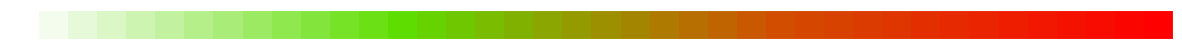

In [53]:
from colour import Color
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
%matplotlib inline

def make_Ramp( ramp_colors ):

    color_ramp = LinearSegmentedColormap.from_list( 'my_list', [ Color( c1 ).rgb for c1 in ramp_colors ] )
    plt.figure( figsize = (15,3))
    plt.imshow( [list(np.arange(0, len( ramp_colors ) , 0.1)) ] , interpolation='nearest', origin='lower', cmap= color_ramp )
    plt.xticks([])
    plt.yticks([])
    return color_ramp

custom_ramp = make_Ramp( ['#ffffff', '#5ede00', '#d24e01', '#ff0000'] )

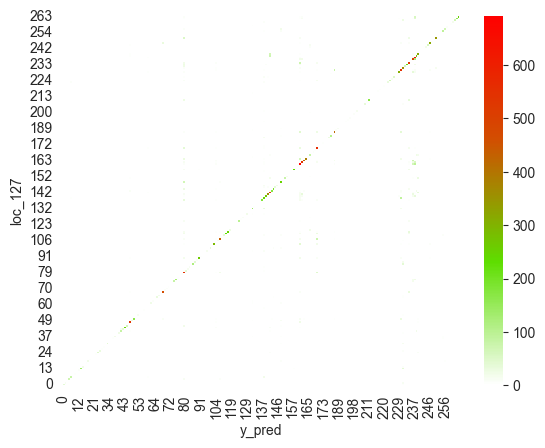

In [54]:
import seaborn as sns

ax = sns.heatmap(matrix,  cmap=custom_ramp)
ax.invert_yaxis()

The model mostly predicts the user to stay in the same location.
Because the taxis often remain in the same area, a in a high accuracy can be achieved by simply predicting the  last location.
This might be because the areas are rather big and trips are often relatively short.

In [55]:
matrix = df.groupby(['y_pred', 'loc_0']).size().unstack(fill_value=0, level=0)
matrix = fill_missing(df, matrix, 'loc_0')
matrix

y_pred,0,1,3,4,7,8,9,10,11,12,...,254,255,256,257,258,259,260,261,262,263
loc_0,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
260,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
261,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,2.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,3.0


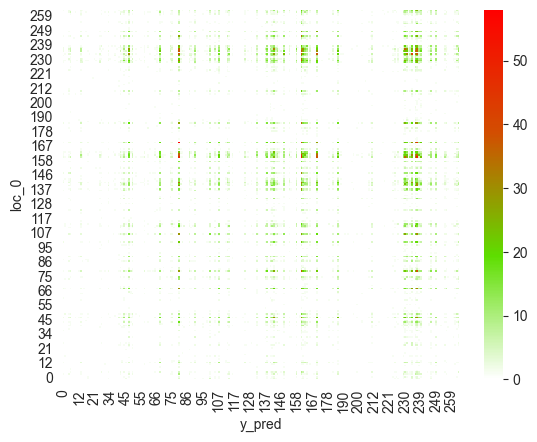

In [56]:
import seaborn as sns

ax = sns.heatmap(matrix,  cmap=custom_ramp)
ax.invert_yaxis()

In [57]:
matrix = df.groupby(['y_pred', 'y_true']).size().unstack(fill_value=0, level=0)
matrix = fill_missing(df, matrix, 'y_true')
matrix

y_pred,0,1,4,7,9,10,11,12,13,14,...,254,255,256,257,258,259,260,261,262,263
y_true,,,,,,,,,,,,,,,,,,,,,
0,21.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,30.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
7,0.0,0.0,0.0,30.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
9,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
260,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0
261,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,23.0,0.0,1.0


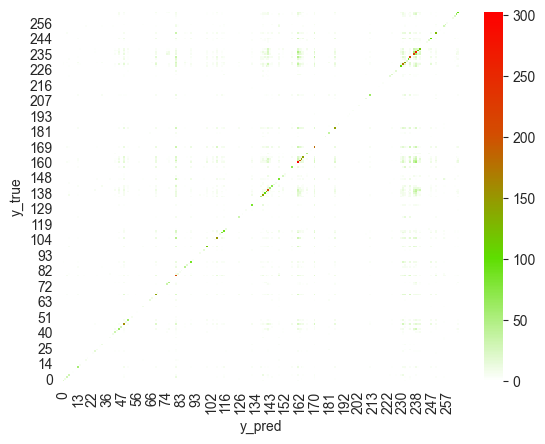

In [58]:
import seaborn as sns

ax = sns.heatmap(matrix,  cmap=custom_ramp)
ax.invert_yaxis()

The most correct predictions can be found where the predicted location was indeed equivalent to the last observed location.